In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import collections
from sklearn import svm
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import spacy
nlp = spacy.load("en_core_web_sm")

2021-12-06 08:58:17.643651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-06 08:58:17.643690: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Loading and Preparing Data

In [2]:
# Loading cleaned, labelled article data as a Pandas dataframe
data = pd.read_excel("Labelled_VR_data_Oct2020_Jan2021_wfulltext.xlsx")

In [3]:
# Converting article status strings to article status indicators.
# 1 = Opinion, 0 = News
def indicator(art_status):
    if art_status == "News":
        return 0
    elif art_status == "Opinion":
        return 1
    else:
        print("Warning: art_status is neither news nor opinion")
        return -1
    
# Applying article indicator conversion function to the dataframe    
data["Article Status Int"] = data["Article Status"].apply(indicator)

In [4]:
# Spltting the article data by news and opinion label
news = data[data["Article Status"] == "News"]
opinion = data[data["Article Status"] == "Opinion"]

In [5]:
# Creating an array of news fulltext strings and another of opinion fulltext strings
news_fulltext_arr = np.array(news["Full Text"])
opinion_fulltext_arr = np.array(opinion["Full Text"])

# SVM Setup

GOAL: Just establish an initial SVM classifier using the linguistic features from the Italian newspaper article and get a baseline f1 score to evaluate initial model quality. Hopefully the code can be a useful reference for future work.

## Setting Up Shiny's Feature Extraction Functions

In [6]:
#linguistic features —  SENTLENGTH and TOKENLENGTH
#hypothesis being that opinion texts, such as editorials, tend to feature longer sentences 
#art_str is the article as a String

def sent_len(art_str):
    """
    Returns the average sentence length measured in tokens (inverted).
    """
    dots = [p for p in range(len(art_str)) if art_str[p] == "."]
    sentences = [dots[i+1] - dots[i] for i in range(len(dots) - 1)]
    return (1/np.average(sentences)) if sentences else (1/len(art_str))
    
def token_len(art_str):
    """
    Returns the average token length measured in characters (inverted).
    """
    wordList = art_str.split()
    lengths = [len(w) for w in wordList]
    return 1/(np.average(lengths)), np.sum(lengths)

In [7]:
#linguistic features — NEGATION and NEGATIONSUFFIX 
#NEGATION — OPINION
#NEGATIONSUFFIX — NEWS
#hypothesis being that opinion texts tend to have more negations 
#n't is used commonly in citations or quotes

negations = ["no", "not", "none", "no one", "nobody", "neither", "nowhere", "nothing", "never"]
neg_suffix = "n\'t"

In [8]:
def negations_count(art_str):
    wordList = art_str.lower().split()
    total, suffix_total = 0, 0
    for w in wordList:
        if w in negations:
            total += 1
        if w[-3:] == neg_suffix:
            suffix_total += 1
    return total, suffix_total
    

In [9]:
#linguistic features — QUESTIONS, EXCLAMATIONS, COMMAS, and SEMICOLONS
#hypothesis being that opinion texts tend to use more exclamations and (rhetorical) questions
#exclamation marks, question marks, semicolons, and commas
#QUESTIONS, EXCLAMATIONS, COMMAS, SEMICOLONS — OPINION
#COMMAS — NEWS
 
def punctuation_count(art_str):
    """
    Determines the numbers of exclamation marks, question marks, semicolons, and commas,
    as compared to other punctuation symbols. 
    """
    count = [0] * 5
    for i in range(len(art_str)):
        if art_str[i] == "?":
            count[0] += 1
        elif art_str[i] == "!":
            count[1] += 1
        elif art_str[i] == ",":
            count[2] += 1
        elif art_str[i] == ";":
            count[3] += 1
        elif art_str[i] == ".":
            count[4] += 1
    return count

In [10]:
#linguistic features — CONNECTIVES (Temporal, Casual, Contrastive, Expansive)
#hypothesis being that there are more connectives in news (aftermath of study)
#casual, expansive, temporal, contrastive — NEWS 


casual = ['after', 'because', 'insofar as', 'by', 'in turn', 'for', 'once', 'as a result', 'hence', 'in the end', 
          'by then', 'but', 'subsequently', 'as', 'therefore', 'unless', 'thus', 'accordingly', 'so that', 'since', 
          'consequently', 'indeed', 'ultimately', 'then', 'even though', 'now that', 'finally”,”hence”,”if', 'although', 
          'so', 'thereby', 'otherwise', 'due to', 'and', 'when']

contrastive = ['nor', 'in fact', 'despite', 'equally', 'by comparison', 'contrast', 'by contrast', 'but', 'separately', 
               'whereas', 'rather', 'meanwhile', 'also', 'even so', 'and', 'though', 'if', 'unlike', 'however', 'or', 'then', 
               'nevertheless', 'yet', 'even though', 'conversely', 'nonetheless', 'on the contrary', 'in contrast', 'while', 
               'likewise', 'instead', 'although', 'on the other hand', 'still', 'similarly', 'otherwise', 'actually', 
               'alternatively', 'on the one hand', 'when']

temporal = ["before", "after", "next", "shortly", "afterwards", "eventually", "firstly", "secondly", "previously", "meanwhile",
            "finally", "while", "then", "earlier", "when", "initially", "soon", "suddenly", "until", "once", "recently", "already", "as"]

expansive = ["also", "and", "as well as", "besides", "in addition", "furthermore", "in fact", "moreover", "additionally",
             "too", "further", "or", "neither", "nor", "either"]

In [11]:
def connective_count(art_str):
    # casual, contrastive, temporal, expansive
    connectives = [0] * 4
    wordList = art_str.lower().split()
    for w in wordList:
        if w in casual:
            connectives[0] += 1
        elif w in contrastive:
            connectives[1] += 1
        elif w in temporal:
            connectives[2] += 1
        elif w in expansive:
            connectives[3] += 1
    return connectives

In [12]:
#linguistic features — PRONOUNS outside of quotes — OPINION
#study used first and second person only


first_person = ['I', 'we', 'our', 'ourselves', 'us', 'me', 'my', 'mine', 'myself']
second_person = ['you', 'yours', 'your', 'yourself', 'yourselves']
third_person = ['he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 
                'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves']

In [13]:
def pronouns_count(art_str):
    wordList = re.sub("[^\w]", " ",  art_str).split()
    pronoun_count = [0] * 4
    for w in wordList:
        """0: 1st person
           1: 2nd person
           2: 3rd person
           3: 1st and 2nd person"""
        w_lower = w.lower()
        if w_lower in first_person:
            pronoun_count[0] += 1
            pronoun_count[3] += 1
        elif w_lower in second_person:
            pronoun_count[1] += 1
            pronoun_count[3] += 1
        elif w_lower in third_person:
            pronoun_count[2] += 1
    return pronoun_count

In [14]:
#linguistic features — CITATIONS and CITATIONLENGTH — OPINION
#hypothesis being that higher frequencies of citations are more indicative of opinion (aftermath of study)

def find_citation(art_str):
    """
    Returns the citation length and frequency in the article. 
    """
    quotes = re.findall(r'"(.*?)"', art_str)
    within_quotes = collections.Counter(" ".join(quotes).lower().split())
    num_citations = len(quotes)
    avg_citation_len = np.average([len(q) for q in quotes])
    return [num_citations, avg_citation_len]

In [15]:
#linguistic features — MODALS — OPINION
#hypothesis being that modal verbs are expected to be a better indicator for opinion 
#according to study, is less potent but do correspond to the genre as expected

modals = ["can", "must", "may", "could", "might", "should", "would", "shall", "ought to"]

In [16]:
#linguistic features — VERBSofSAYING (VoS) — NEWS
#hypothesis that vos more common in news

vos = ['acknowledge','affirm','allege','announce','assert','claim','comment','contend','declare','disclose',
       'exclaim','explain','insist','mention','notify','observe','proclaim','propose','report','reveal','said','say','state',
       'stipulate','tell','write']

In [17]:
#linguistic features — FUTURE_WILL — NEWS
#frequency of the verb, "will" outside of quotes

future_will = "will"

In [18]:
#linguistic features — DIGITS — OPINION
#hypothesis being that digits are more frequent in opinion than news (aftermath of study)

def count_digits(art_str):
    """
    Returns the frequency of digits in a text. 
    """
    return len(re.findall("[\d]+",art_str))/len(art_str)

In [19]:
finite_verb_tags = ["VBD", "VBP", "VBZ", "MD", "BES", "HVS"]

In [20]:
#complexity and finite verbs

def get_finite_verbs(art_str):
    finite_verb_tags = ["VBD", "VBP", "VBZ", "MD", "BES", "HVS"]
    return [w for w in nlp(art_str) if w.tag_ in finite_verb_tags]

def calc_complexity(art_str):
    num_finite_verbs = len(get_finite_verbs(art_str))
    complexity = num_finite_verbs / token_len(art_str)[1]
    return complexity

In [21]:
#present and past tense frequency

def present_tense_freq(finite_verbs):
    present_verbs = [w for w in finite_verbs if w.tag_ == "VBZ" or w.tag_ == "VBP"]
    present_tense_frequency = len(present_verbs) / len(finite_verbs)
    return present_tense_frequency

def past_tense_freq(finite_verbs):
    past_verbs = [w for w in finite_verbs if w.tag_ == "VBD"]
    past_tense_frequency = len(past_verbs) / len(finite_verbs)
    return past_tense_frequency

In [22]:
#interjection frequency

def get_interjections(art_str):
    interjections = [w for w in nlp(art_str) if w.pos_ == "INTJ"]
    intj_freq = len(interjections) / token_len(art_str)[1]
    return intj_freq

In [23]:
# Subjectivity Dictionary
import json
mpqa_dict = json.load(open("mpqa_dict.json", "r"))

print(len(mpqa_dict))

6778


In [24]:
#linguistic features — SENTIMENT — OPINION
#hypothesis being that opinion texts employ a less neutral language
#calculated in study using MPQA Subjectivity Clues Lexicon 

def get_sentiment(art_str, mpqa_dict):
    subjectivity, adjectives = 0, 0
    words = art_str.lower().split()
    
    for w in words:
        if w in mpqa_dict:  
            if mpqa_dict[w]['pos'] == 'adj':
                adjectives += 1
            if mpqa_dict[w]['subj'] == 'weaksubj':
                subjectivity += 0.1
            if mpqa_dict[w]['subj'] == 'strongsubj':
                subjectivity += 1
          
    num_words = len(words)
    sentiment = subjectivity / num_words
    adj_ratio = adjectives / num_words
    
    return subjectivity, sentiment, adjectives, adj_ratio

In [25]:
quote_pattern = "'[^']*'"

## Adding in David's Features

In [26]:
# Cleaning string-based columns by filling na values with empty strings
data["Full Text"].fillna("");
data["Journalist Name"].fillna("");
data["Headline"].fillna("");

In [27]:
#Headline length feature
#On average, news headlines are slightly longer than opinion headlines
#df.groupby(["news_opinion"])["headline_length"].mean()
data["headline_length_feature"] = data["Headline"].str.len()

#Author count feature
#News articles tend to have slightly more authors
#df.groupby(["news_opinion","author_count"]).size()
data["author_count_feature"] = data["Cleaned Author"].str.count(", ") + 1

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
a = data["Headline"].str.len()
b = data["Cleaned Author"].str.count(", ") + 1
zipped = list(zip(a,b))
fitted = scaler.fit(zipped)
arr = scaler.transform(zipped)
t = zip(*arr)
new = list(t)
data['minmax_length'] = new[0]
data['minmax_author'] = new[1]

In [29]:
data['minmax_length'] = data['minmax_length'].fillna(0);
data['minmax_author'] = data['minmax_author'].fillna(0);

In [30]:
m1 = max(data["headline_length_feature"])
normalized1 = data["headline_length_feature"]/m1
data['normalized_length'] = normalized1
m2 = max(data["author_count_feature"])
normalized2 = data["author_count_feature"]/m2
data['normalized_author_count'] = normalized2

In [31]:
data['normalized_length'] = data['normalized_length'].fillna(0);
data['normalized_author_count'] = data['normalized_author_count'].fillna(0);

## Total Feature Extraction Function

In [32]:
# Modified version of Shiny's feature extraction function with David's features added, 
# plus some runtime optimizations

def get_all_featuresf(record, df):
    
    # Features with no for loops
    art_str = record["Full Text"]
    minmax_length = record["minmax_length"]
    minmax_author = record["minmax_author"]
    normalized_length = record["normalized_length"]
    normalized_author_count = record["normalized_author_count"]
    
    counter = collections.Counter(art_str.lower().split())
    num_words = sum(list(counter.values()))
    
    quotes = re.findall(r'"(.*?)"', art_str)
    within_quotes = collections.Counter(" ".join(quotes).lower().split())
    num_citations = len(quotes)
    avg_citation_len = np.average([len(q) for q in quotes]) if quotes else 0
    sent_length = sent_len(art_str)
    token_length, num_tokens = token_len(art_str) 
    
    # Things we need to count
    num_modals, num_vos = 0, 0
    num_casual, num_temporal, num_contrastive, num_expansive = 0, 0, 0, 0
    first_p, second_p, third_p, first_second_p = 0, 0, 0, 0
    num_future = counter.get("will") or 0
    opinion_count, news_count = 0, 0
    num_negation, negation_suffix = 0, 0
    num_finite_verbs = 0
    digits = 0
    num_past_tense, num_pres_tense = 0, 0
    num_intjs = 0
    
    # Features with for loops
    for w in counter.keys():
        if w in vos:
            num_vos += counter.get(w)
        if w in first_person:
            first_p += counter.get(w)
            first_second_p += counter.get(w)
        if w in second_person:
            second_p += counter.get(w)
            first_second_p += counter.get(w)
        if w in third_person:
            third_p += counter.get(w)
        if w in modals:
            num_modals += counter.get(w)
        if w in casual:
            num_casual += counter.get(w)
        if w in temporal:
            num_temporal += counter.get(w)
        if w in contrastive:
            num_contrastive += counter.get(w)
        if w in expansive:
            num_expansive += counter.get(w)
        if any(char.isdigit() for char in w):
            digits += 1
        if w in opinion:
            opinion_count += counter.get(w)
        if w in news:
            news_count += counter.get(w)
        if "n't" in w:
            negation_suffix += counter.get(w)
        if w in negations:
            num_negation += counter.get(w)
    
    for w in nlp(art_str):
        if w.tag_ in finite_verb_tags:
            num_finite_verbs += 1
        if w.tag_ == "VBZ" or w.tag_ == "VBP":
            num_pres_tense += 1
        if w.tag_ == "VBD":
            num_past_tense += 1
    
    # Other 
    if num_tokens == 0:
        comlexity, interjection_freq = 0, 0
    else: 
        complexity = num_finite_verbs / num_tokens
        interjection_freq = num_intjs / num_tokens
    if num_finite_verbs == 0:
         past_freq, present_freq = 0, 0
    else:
        past_freq = num_past_tense / num_finite_verbs
        present_freq = num_pres_tense / num_finite_verbs
    
    subjectivity, sentiment, adjectives, adj_ratio = get_sentiment(art_str, mpqa_dict)
    questions, exclamations, semicolons, commas, periods = punctuation_count(art_str)
    
    # Compilation
    ling_features = [sent_length, token_length, first_p, second_p, third_p, first_second_p,
                    questions, exclamations, semicolons, commas, periods, 
                    num_casual, num_temporal, num_contrastive, num_expansive, 
                    digits, num_modals, num_vos, num_future, 
                    opinion_count, news_count,
                    num_negation, negation_suffix, num_citations, avg_citation_len, num_words,
                    subjectivity, sentiment, adjectives, adj_ratio,
                    minmax_length, minmax_author, normalized_length, normalized_author_count,
                    complexity, present_freq, past_freq, interjection_freq]
    return ling_features

In [33]:
# Preparing to create a dataframe where each record is a full text, and each column is a feature

# Collecting the label for each record in an array
y = []
count = 1
total = len(data)
for article_label in data["Article Status Int"]:
    y.append(article_label)
y = np.array(y)

# Collecting the features for each record in an array
X = []
for index, record in data.iterrows():
    article_features = get_all_featuresf(record, data)
    X.append(article_features)
    
    #if count == 1701: # FIXME REMOVE THIS STOPPER STRAWBERRY
    #    break
    if count%100 == 0:
        print(str(count) + " of " + str(total))
    count += 1
    
X = np.array(X)
 

100 of 3535
200 of 3535
300 of 3535
400 of 3535
500 of 3535
600 of 3535
700 of 3535
800 of 3535
900 of 3535
1000 of 3535
1100 of 3535
1200 of 3535
1300 of 3535
1400 of 3535
1500 of 3535
1600 of 3535
1700 of 3535
1800 of 3535
1900 of 3535
2000 of 3535
2100 of 3535
2200 of 3535
2300 of 3535
2400 of 3535
2500 of 3535
2600 of 3535
2700 of 3535
2800 of 3535
2900 of 3535
3000 of 3535
3100 of 3535
3200 of 3535
3300 of 3535
3400 of 3535
3500 of 3535


In [34]:
# Creating a reference for the features and target variables we are considering
X_cols = ['sent_length', 'token_length', 'first_p', 'second_p', 'third_p', "first/second_p",
                    'questions', 'exclamations', 'semicolons', 'commas', 'periods', 
                    'num_casual', 'num_temporal', 'num_contrastive', 'num_expansive', 
                    'digits', 'num_modals', 'num_vos', 'num_future', 
                    'opinion_count', 'news_count',
                    'num_negation', 'negation_suffix', 'num_citations', 'avg_citation_len', 'num_words',
                    'subjectivity', 'sentiment', 'adjectives', 'adj_ratio',
                    'minmax_length', 'minmax_author', 'normalized_length', 'normalized_author_count', 
                    'complexity', 'present', 'past', 'interjections']
X_cols_reduced = ['sent_length', 'token_length', 'first_p', "first/second_p",
                    'questions', 'semicolons', 'commas', 'periods', 
                    'num_casual','num_contrastive',
                    'digits', 'num_modals', 'num_vos',
                    'avg_citation_len', 'num_words']
y_col = ['art_status']

In [35]:
# Creating a dataframe where each record is a full text, and each column is a feature

data_wfeats = pd.DataFrame(X, columns=X_cols)#.head(1701) # FIXME GET FULL DF STRAWBERRY
data_wfeats = data_wfeats[X_cols] # FIXME RETURN TO FULL X COLS?
data_wfeats['art_status'] = y#[:1701] # FIXME GET FULL DF STRAWBERRY
#data_wfeats.head()

In [36]:
nan_values = data_wfeats.isna()
nan_columns = nan_values.any()
nan_columns

sent_length                False
token_length               False
first_p                    False
second_p                   False
third_p                    False
first/second_p             False
questions                  False
exclamations               False
semicolons                 False
commas                     False
periods                    False
num_casual                 False
num_temporal               False
num_contrastive            False
num_expansive              False
digits                     False
num_modals                 False
num_vos                    False
num_future                 False
opinion_count              False
news_count                 False
num_negation               False
negation_suffix            False
num_citations              False
avg_citation_len           False
num_words                  False
subjectivity               False
sentiment                  False
adjectives                 False
adj_ratio                  False
minmax_len

In [37]:
#null_cols = ["minmax_author","normalized_author_count"]#,"avg_citation_len"]

In [38]:
#data_wnonnafeats = data_wfeats.drop(columns=null_cols)

In [39]:
#for null_col in null_cols:
#    X_cols.remove(null_col)

### Some EDA

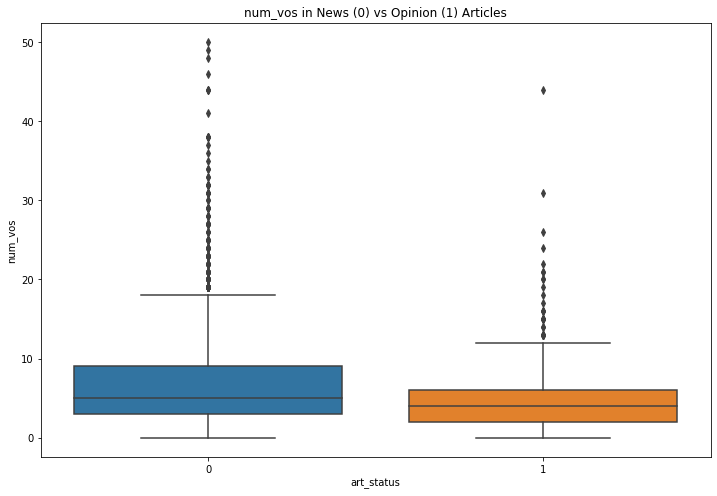

In [40]:
plt.figure(figsize=[12,8]);
sns.boxplot(x="art_status", y="num_vos", data=data_wfeats);
plt.title("num_vos in News (0) vs Opinion (1) Articles");

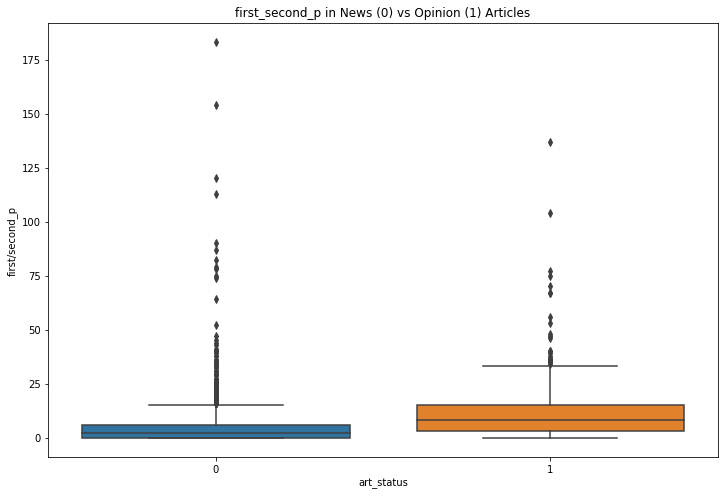

In [41]:
plt.figure(figsize=[12,8]);
sns.boxplot(x="art_status", y="first/second_p", data=data_wfeats);
plt.title("first_second_p in News (0) vs Opinion (1) Articles");

In [42]:
# Dropping records from this dataframe where feature values are missing
data_wnonnafeats = data_wfeats.dropna()
data_wnonnafeats

# FIXME Check to see how many records we lost

,sent_length,token_length,first_p,second_p,third_p,first/second_p,questions,exclamations,semicolons,commas,...,adj_ratio,minmax_length,minmax_author,normalized_length,normalized_author_count,complexity,present,past,interjections,art_status
0,0.014900,0.201974,1.0,2.0,44.0,3.0,0.0,0.0,78.0,3.0,...,0.036988,0.142232,0.00,0.156989,0.2,0.018143,0.316176,0.602941,0.0,0
1,0.007716,0.190626,9.0,3.0,51.0,12.0,1.0,0.0,92.0,3.0,...,0.051511,0.105033,0.00,0.120430,0.2,0.017806,0.720588,0.125000,0.0,0
2,0.021549,0.200954,1.0,0.0,21.0,1.0,0.0,0.0,30.0,1.0,...,0.022152,0.155361,0.25,0.169892,0.4,0.015262,0.125000,0.770833,0.0,0
3,0.007221,0.187560,5.0,0.0,20.0,5.0,0.0,0.0,31.0,1.0,...,0.044643,0.155361,0.00,0.169892,0.2,0.013397,0.446429,0.178571,0.0,1
4,0.006043,0.187835,1.0,0.0,20.0,1.0,0.0,0.0,50.0,0.0,...,0.025397,0.113786,0.25,0.129032,0.4,0.016696,0.523810,0.321429,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3530,0.008160,0.197435,4.0,0.0,22.0,4.0,1.0,0.0,31.0,0.0,...,0.023004,0.221007,0.00,0.234409,0.0,0.022175,0.457831,0.325301,0.0,0
3531,0.007276,0.210563,8.0,4.0,25.0,12.0,0.0,1.0,33.0,0.0,...,0.039344,0.199125,0.00,0.212903,0.0,0.023127,0.552239,0.223881,0.0,0
3532,0.011149,0.197375,3.0,4.0,33.0,7.0,4.0,0.0,73.0,0.0,...,0.040245,0.172867,0.25,0.187097,0.4,0.022449,0.292308,0.607692,0.0,0
3533,0.009121,0.190674,0.0,0.0,0.0,0.0,0.0,0.0,28.0,1.0,...,0.000000,0.153173,0.00,0.167742,0.2,0.008057,0.939394,0.060606,0.0,0


In [43]:
from sklearn.model_selection import train_test_split

# Train test split for articles in our dataset
train, test = train_test_split(data_wnonnafeats, test_size=0.30, random_state=42)

In [44]:
# Defining the data matrix and label vector for train and test data sets
X_train = train[X_cols].to_numpy() # FIXME RETURN TO FULL X COLS?
y_train = train[y_col].to_numpy().flatten()

X_test = test[X_cols].to_numpy()  # FIXME RETURN TO FULL X COLS?
y_test = test[y_col].to_numpy().flatten()

## Assessing initial model quality

In [ ]:
# Fitting a support vector classifier on X_train and y_train
svc = svm.SVC(C=0.6, kernel='linear') #FIXME C is 1 by default
svc.fit(X_train, y_train)

In [63]:
from sklearn.metrics import f1_score

# Evaluating SVM performance on test data
y_pred = svc.predict(X_test)
#y_pred = (svc.predict_proba(X_test)[:,1] >= 0.3).astype(int)
y_true = y_test

# Initial f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score with Linear Kernel: " + str(f1))

AttributeError: 'SVC' object has no attribute 'shape_fit_'

In [47]:
# We prefer FP to FN, which means we prioritize high recall in our model
recall = recall_score(y_true, y_pred)
print("Recall with Linear Kernel: " + str(recall))

Recall with Linear Kernel: 0.42528735632183906


In [49]:
# Obtaining specificity, which is more related to false positives. If it comes down to it,
# We would prefer a higher recall to a higher sensitivity since that minimizes false negatives
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)
print("Specificity with Linear Kernel: " + str(specificity))

Specificity with Linear Kernel: 0.9706877113866967


# Visualizing Model Quality

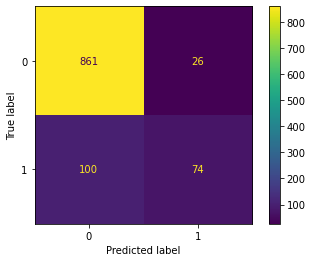

In [50]:
# Visualizing the confusion matrix:
plot_confusion_matrix(svc, X_test, y_test) 

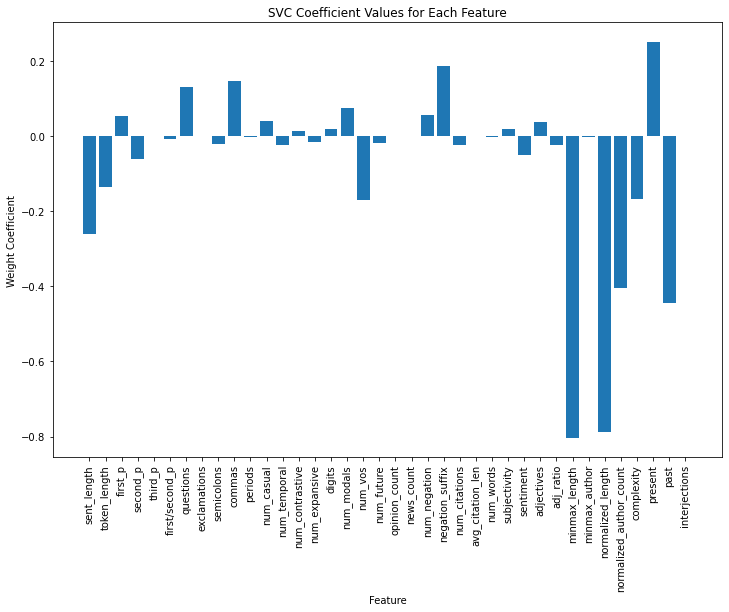

In [60]:
coefs = svc.coef_.flatten()
plt.figure(figsize=[12,8]);
plt.bar(x=X_cols,height=coefs);
plt.xticks(rotation='90');
plt.ylabel("Weight Coefficient");
plt.xlabel("Feature");
plt.title("SVC Coefficient Values for Each Feature");

# NOTE: 

### Sections below were early tests for heuristic viability and as such may be imcompatible with changes to the code made above. They are left purely for documentation.

# SVM with Heuristic Filter

In [ ]:
class heurSVM:

    def __init__(self):
        self.heuristics = {}
        self.svc = svm.SVC(kernel='linear')
    
    def fit(self, heuristics, X, y):
        self.heuristics = heuristics
        self.svc.fit(X, y)
        
    def predict(self, X):
        def classify(text):
            for heuristic in self.heuristics.keys():
                if heuristic in text:
                    return self.heuristics[heuristic]
                else:
                    return self.svc.predict(X)
        return classify(X)

In [ ]:
hSVM = heurSVM()
heuristics = {"reporting by": "News", "editing by": "News", "contributed to this report": "News"}
hSVM.fit(heuristics, X_train, y_train)
y_pred = hSVM.predict(X_test)
y_true = y_test
print("F1 Score with rules-based filter: " + str(f1_score(y_true, y_pred, average='macro')))

# SVM with heuristics as features

In [ ]:
# Old feature extractiono function but with indicator variables for presence of heuristic phrases
def get_all_features(record, df):
    art_str = record["Full Text"]
    counter = collections.Counter(art_str.lower().split())
    num_words = sum([counter.get(w) for w in counter.keys()])
    
    has_reportingby = int("reporting by" in art_str)
    has_editingby = int("editing by" in art_str)
    has_contributedto = int("contributed to this report" in art_str)
    headline_length = record["headline_length_feature"]
    author_count = record["author_count_feature"]
    minmax_length = record["minmax_length"]
    minmax_author = record["minmax_author"]
    normalized_length = record["normalized_length"]
    normalized_author_count = record["normalized_author_count"]
    
    subjectivity, sentiment, adjectives, adj_ratio = get_sentiment(art_str, mpqa_dict)
    questions, exclamations, semicolons, commas, periods = punctuation_count(art_str)
    first_p, second_p, third_p = 0, 0, 0
    num_modals, num_vos = 0, 0
    num_casual, num_temporal, num_contrastive, num_expansive = 0, 0, 0, 0
    digits = 0
    num_future = counter.get("will")
    opinion_count, news_count = 0, 0
    num_negation, negation_suffix = 0, 0
    quotes = re.findall(r'"(.*?)"', art_str)
    within_quotes = collections.Counter(" ".join(quotes).lower().split())
    num_citations = len(quotes)
    avg_citation_len = np.average([len(q) for q in quotes])
    sent_length = sent_len(art_str)
    token_length = token_len(art_str)
    
    for w in counter.keys():
        if w in vos:
            num_vos += counter.get(w)
        elif w in first_person:
            first_p += counter.get(w)
        elif w in second_person:
            second_p += counter.get(w)
        elif w in third_person:
            third_p += counter.get(w)
        elif w in modals:
            num_modals += counter.get(w)
        elif w in casual:
            num_casual += counter.get(w)
        elif w in temporal:
            num_temporal += counter.get(w)
        elif w in contrastive:
            num_contrastive += counter.get(w)
        elif w in expansive:
            num_expansive += counter.get(w)
        elif any(char.isdigit() for char in w):
            digits += 1
        elif w in opinion:
            opinion_count += counter.get(w)
        elif w in news:
            news_count += counter.get(w)
        elif "n't" in w:
            negation_suffix += counter.get(w)
        elif w in negations:
            num_negation += counter.get(w)
            
    ling_features = [sent_length, token_length, first_p, second_p, third_p, 
                    questions, exclamations, semicolons, commas, periods, 
                    num_casual, num_temporal, num_contrastive, num_expansive, 
                    digits, num_modals, num_vos, num_future, 
                    opinion_count, news_count,
                    num_negation, negation_suffix, num_citations, avg_citation_len, num_words,
                    subjectivity, sentiment, adjectives, adj_ratio,
                    headline_length, author_count, minmax_length, minmax_author, normalized_length,
                    normalized_author_count,
                    has_reportingby, has_editingby, has_contributedto]
    
    return ling_features

In [ ]:
# Preparing to create a dataframe where each record is a full text, and each column is a feature

# Collecting the label for each record in an array
y = []
for article_label in data["Article Status"]:
    y.append(article_label)
y = np.array(y)

# Collecting the features for each record in an array
X = []
for index, record in data.iterrows():
    article_features = get_all_features(record, data)
    X.append(article_features)
X = np.array(X)

In [ ]:
# Creating a reference for the features and target variables we are considering
X_cols = ['sent_length', 'token_length', 'first_p', 'second_p', 'third_p', 
                    'questions', 'exclamations', 'semicolons', 'commas', 'periods', 
                    'num_casual', 'num_temporal', 'num_contrastive', 'num_expansive', 
                    'digits', 'num_modals', 'num_vos', 'num_future', 
                    'opinion_count', 'news_count',
                    'num_negation', 'negation_suffix', 'num_citations', 'avg_citation_len', 'num_words',
                    'subjectivity', 'sentiment', 'adjectives', 'adj_ratio',
                    'headline_length', 'author_count', 'minmax_length', 'minmax_author', 'normalized_length',
                    'normalized_author_count',
                    'has_reportingby', 'has_editingby', 'has_contributedto']
y_col = ['art_status']

In [ ]:
# Fitting a support vector classifier on X_train and y_train
svc = svm.SVC(kernel='linear')
svc.fit(X_train, y_train)

In [ ]:
# Evaluating SVM performance on test data
y_pred = svc.predict(X_test)
y_true = y_test

# Initial f1 score
print("F1 Score with heuristics as features: " + str(f1_score(y_true, y_pred, average='macro')))

In [1]:
data

NameError: name 'data' is not defined